<a href="https://www.kaggle.com/code/ikomanggg28/pneumonia-classification-tensorflow?scriptVersionId=145416790" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia/person1947_bacteria_4876.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia/person1946_bacteria_4875.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia/person1952_bacteria_4883.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia/person1954_bacteria_4886.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia/person1951_bacteria_4882.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia/person1946_bacteria_4874.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia/person1949_bacteria_4880.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/pneumonia/person1950_bacteria_4881.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/normal/NORMAL2-IM-1431-0001.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/normal/NORMAL2-IM-1440-0001.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/normal/NORMAL2-IM-1442-0001.jpeg
/kaggle/input/pneumonia-chest-x-ray-dataset/val/norma

In [2]:
import os
import cv2
import random
import shutil
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_dir = '/kaggle/input/pneumonia-chest-x-ray-dataset/train'
test_dir = '/kaggle/input/pneumonia-chest-x-ray-dataset/test'
validation_dir = '/kaggle/input/pneumonia-chest-x-ray-dataset/val'

In [4]:
classes = os.listdir(train_dir)
print(classes)

['pneumonia', 'normal']


In [5]:
X = []
y = []
image_size = 150
for i in classes:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)
        
for i in classes:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X.append(img)
        y.append(i)
        
X = np.array(X)
y = np.array(y)

100%|██████████| 234/234 [00:07<00:00, 32.98it/s]


In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=101)

In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(classes.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(classes.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale = 1./255.,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip = True)

img_datagen.fit(X_train)
img_datagen.fit(X_test)

In [9]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D

In [10]:
base_model=MobileNet(weights='imagenet',include_top=False,input_shape = (150,150, 3))
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
preds=Dense(2,activation='softmax')(x)

17225924/17225924 [==============================] - 0s 0us/step


In [11]:
len(base_model.layers)

86

In [12]:
model_mobilenet=Model(inputs=base_model.input,outputs=preds)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model_mobilenet.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 75, 75, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 75, 75, 32)       128       
 ation)                                                      

In [14]:
history = model_mobilenet.fit(X_train, y_train,
                              epochs=10,
                              validation_data=(X_test, y_test),
                              verbose=1)

Epoch 1/10
146/146 [==============================] - 29s 61ms/step - loss: 0.2432 - accuracy: 0.9120 - val_loss: 0.1503 - val_accuracy: 0.9503
Epoch 2/10
146/146 [==============================] - 8s 51ms/step - loss: 0.1089 - accuracy: 0.9613 - val_loss: 0.1084 - val_accuracy: 0.9666
Epoch 3/10
146/146 [==============================] - 8s 52ms/step - loss: 0.0679 - accuracy: 0.9775 - val_loss: 0.0847 - val_accuracy: 0.9760
Epoch 4/10
146/146 [==============================] - 8s 53ms/step - loss: 0.0426 - accuracy: 0.9863 - val_loss: 0.0756 - val_accuracy: 0.9769
Epoch 5/10
146/146 [==============================] - 8s 52ms/step - loss: 0.0245 - accuracy: 0.9934 - val_loss: 0.0919 - val_accuracy: 0.9709
Epoch 6/10
146/146 [==============================] - 8s 53ms/step - loss: 0.0147 - accuracy: 0.9964 - val_loss: 0.0831 - val_accuracy: 0.9735
Epoch 7/10
146/146 [==============================] - 8s 53ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.0819 - val_accuracy: 0.976

In [15]:
def plot_acc_model(acc, val_acc, epochs):
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    
def plot_loss_model(loss, val_loss, epochs):
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

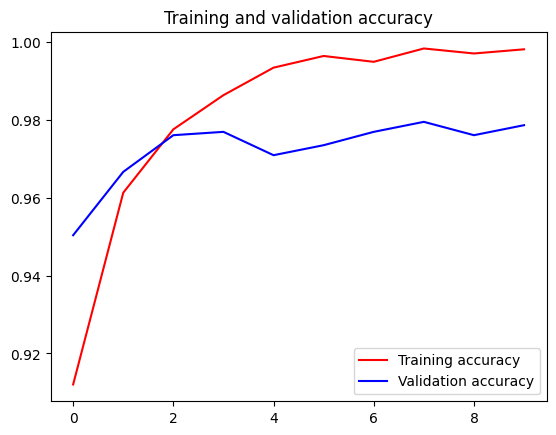

<Figure size 640x480 with 0 Axes>

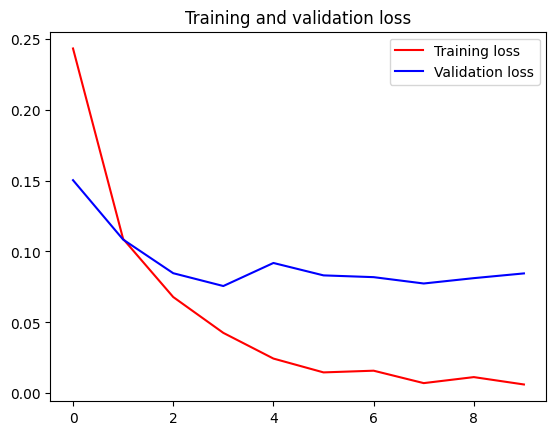

<Figure size 640x480 with 0 Axes>

In [17]:
plot_acc_model(acc, val_acc, epochs)
plot_loss_model(loss, val_loss, epochs)

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def confussion_matrix(test_true, test_pred, test_class):
    cm = confusion_matrix(test_true, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class)
    fig, ax = plt.subplots(figsize=(15,15))
    disp.plot(ax=ax,cmap=plt.cm.Blues)
    plt.show()

In [19]:
def data_generators(VALIDATION_DIR):

  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  
  validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))

  return validation_generator

In [20]:
validation_generator = data_generators(validation_dir)

Found 16 images belonging to 2 classes.


1/1 [==============================] - 1s 586ms/step


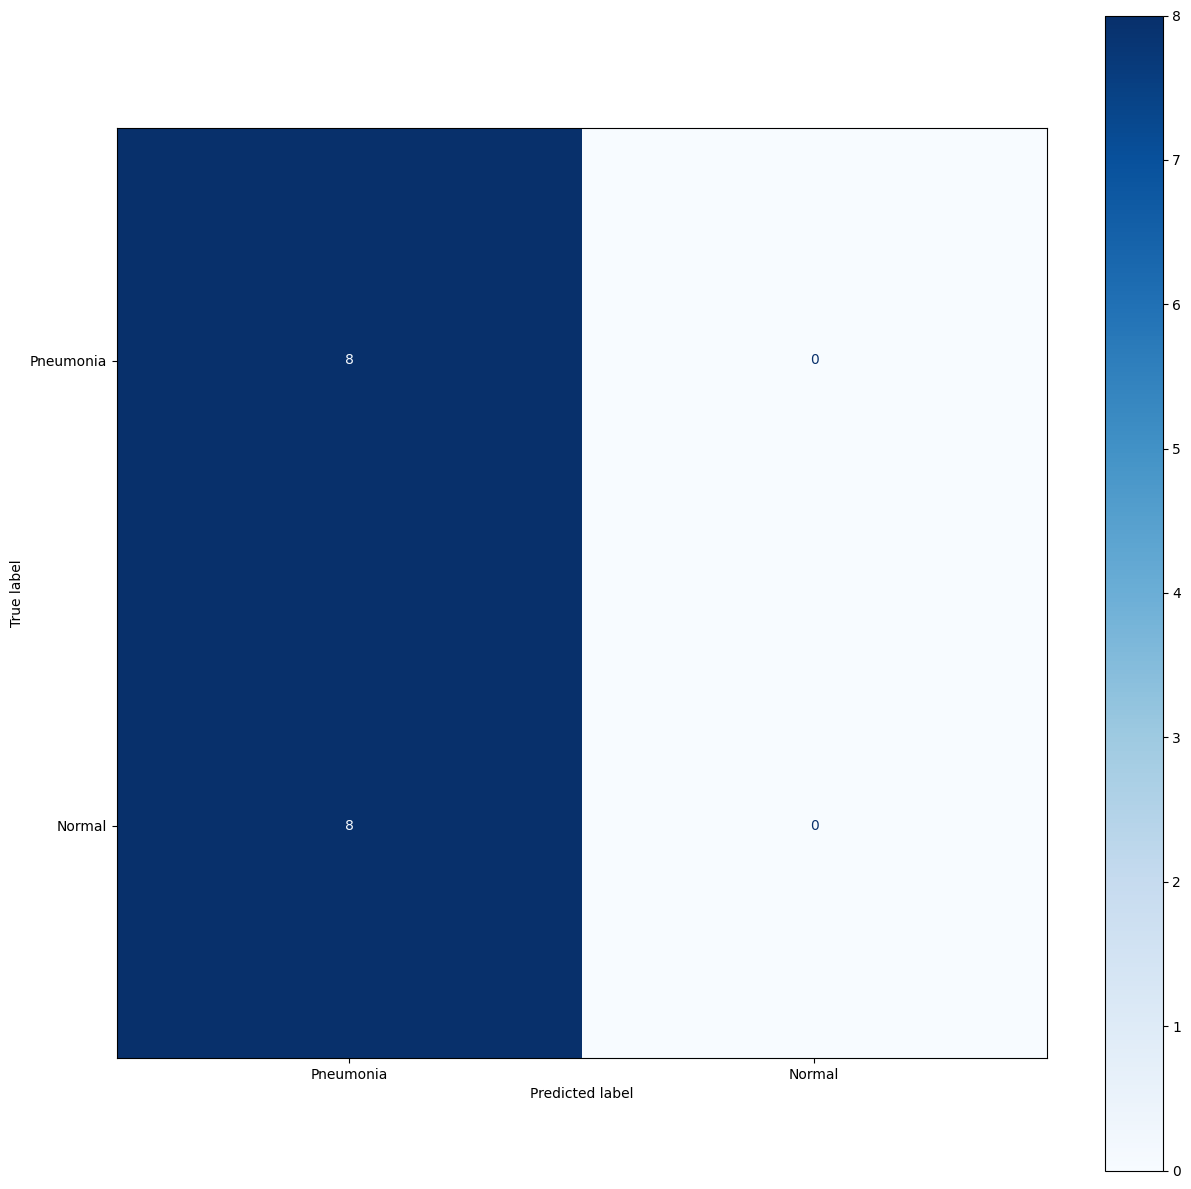

In [21]:
testing_pred_raw = model_mobilenet.predict(validation_generator)
testing_pred = np.argmax(testing_pred_raw, axis=1)
testing_true = validation_generator.classes
testing_class = ["Pneumonia","Normal"]
confussion_matrix(testing_true, testing_pred, testing_class)